Introduction and importing dependencies

In [62]:
!pip install --upgrade pip setuptools
!pip install tensorflow opencv-python matplotlib
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [63]:
pip install --upgrade opencv-python-headless

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [64]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt

In [65]:
#importing tensor flow Dependencies - Functional API
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten


In [66]:
#Limiting GPU Memory consumption growth so we do not run into out of memory exeption/error
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.set_memory_growth(gpu, True)

#List of All available GPUs(Currently list of GPUs is empty because my laptop does not come with any built-in GPU)
gpus

[]

In [67]:
#Defining Folder Structures
POS_PATH = os.path.join('data','positive')
NEG_PATH = os.path.join('data','negative') 
ANC_PATH = os.path.join('data','anchor')

In [68]:
# #Creating the required directories
# os.makedirs(POS_PATH)
# os.makedirs(NEG_PATH)
# os.makedirs(ANC_PATH)

Unpacking Labelled Faces, Collecting Anchor/ Positive Images

In [69]:
import uuid

In [70]:
# We establish a connection to the webcam
cap = cv2.VideoCapture(0)

# Looping through every single frame in the webcam
while cap.isOpened():   
    # Return value is boolean and tells us if the video capture device is working
    # Frame returns the current frame as an image
    ret, frame = cap.read()

    frame = frame[200:200+250, 500:500+250, :]

    #Collecting Anchors
    if cv2.waitKey(1) & 0xFF == ord('a'):
        #Creating unique name/filepath
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        #Write the anchor image to the path
        cv2.imwrite(imgname, frame)
    #Collecting Positives
    if cv2.waitKey(1) & 0xFF == ord('p'):
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        #Write the anchor image to the path
        cv2.imwrite(imgname, frame)
        
    # Renders the returned frame in a window on the screen titled 'Image Captured'
    cv2.imshow('Image Captured', frame)
    
    # If the 'q' key is pressed then the system exits the current running window
    if cv2.waitKey(1) & 0xFF == ord('q'):
        print("Exiting....")
        break
    
# Release the webcam
cap.release()
# Destroy the specific window
cv2.destroyWindow('Image Captured')
# Ensure all windows are closed
cv2.destroyAllWindows()
print("Webcam released and all related windows closed")

Exiting....
Webcam released and all related windows closed


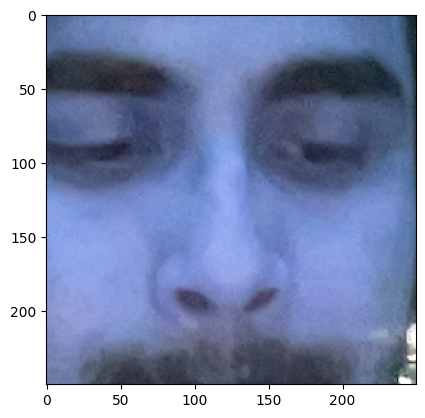

In [71]:
plt.imshow(frame)

In [72]:
#Fetching the image directories
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

In [73]:
ANC_PATH+'/*.jpg'

'data/anchor/*.jpg'

In [74]:
dir_test = anchor.as_numpy_iterator()

In [75]:
print(dir_test.next())

b'data/anchor/ed5215e4-1ea7-11ef-8d16-be8281faaadb.jpg'


In [76]:
#image preprocessing function
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img) #load in the image using the decode method
    #Preprocessing steps
    img = tf.image.resize(img, (100, 100))#resizing image to be 100pX100pX3channels
    img = img/255.0 #Normalization
    return img

In [77]:
img = preprocess('data/anchor/dc84ffdc-1ea8-11ef-8d16-be8281faaadb.jpg')

In [78]:
#Printing the scale of the darkest to the lightest pixel
#Usually min() = 0 because the darkest pixel is black
#max() value is the lightest pixel . Here there is no field of white so the vlaue is slightly less than 1
print(img.numpy().min())
print("to")
print(img.numpy().max())

0.0
to
0.9884804


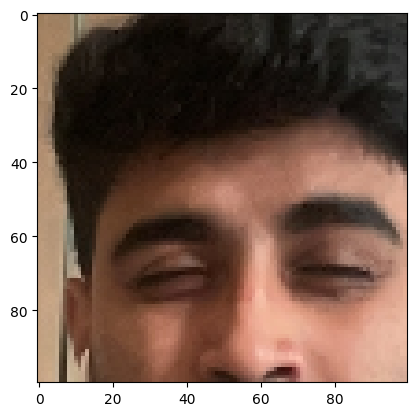

In [79]:
plt.imshow(img)

Creating Labelled Dataset

In [80]:
#(anchor, positive) => 1,1,1,1,1
#(anchor, negative) => 0,0,0,0,0

In [81]:
class_labels = tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))

In [82]:
iterator_labs = class_labels.as_numpy_iterator()

In [83]:
positives = tf.data.Dataset.zip(anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor))))
negatives = tf.data.Dataset.zip(anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor))))
data=positives.concatenate(negatives)

In [84]:
samples = data.as_numpy_iterator()

In [85]:
example = samples.next()

In [86]:
example

(b'data/anchor/453f208e-1e27-11ef-844f-be8281faaadb.jpg',
 b'data/positive/5c0260e8-1ea8-11ef-8d16-be8281faaadb.jpg',
 1.0)

Train test partitioning

In [87]:
def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)

In [88]:
res = preprocess_twin(*example)

In [89]:
res[0]

<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
array([[[0.23970588, 0.22009803, 0.24362744],
        [0.21642157, 0.19681373, 0.22034314],
        [0.23112746, 0.20563726, 0.23210785],
        ...,
        [0.31789216, 0.3009804 , 0.23602942],
        [0.29583332, 0.2723039 , 0.20955883],
        [0.25392157, 0.23039216, 0.16764706]],

       [[0.24191177, 0.22132353, 0.23504902],
        [0.2120098 , 0.19068627, 0.20441176],
        [0.21691176, 0.19338235, 0.20122549],
        ...,
        [0.30661765, 0.30490196, 0.23161764],
        [0.29460785, 0.28627452, 0.21593137],
        [0.2784314 , 0.26862746, 0.19313726]],

       [[0.22696078, 0.20343137, 0.2112745 ],
        [0.27107844, 0.23872548, 0.24362744],
        [0.24705882, 0.21470588, 0.21813725],
        ...,
        [0.28284314, 0.28112745, 0.20196079],
        [0.28112745, 0.27720588, 0.19877452],
        [0.28039217, 0.2764706 , 0.19803922]],

       ...,

       [[0.8029412 , 0.6818628 , 0.46617648],
        [0.58

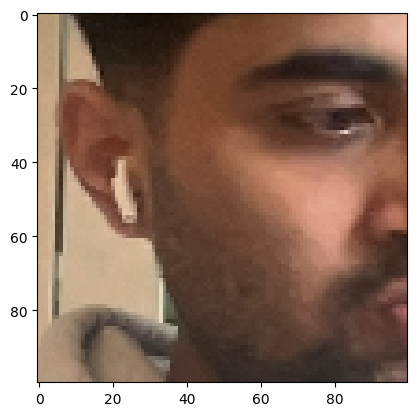

In [90]:
plt.imshow(res[1])

In [91]:
res[2]

1.0

In [92]:
#Building a data loader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)


Model Engineering